<a href="https://colab.research.google.com/github/HarshSonaiya/DL/blob/main/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2024-10-08 09:49:44--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  19.9MB/s    in 98s     

2024-10-08 09:51:22 (19.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2024-10-08 09:51:22--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[========

In [ ]:
! tar xf VOCtrainval_11-May-2012.tar
! tar xf VOCtrainval_06-Nov-2007.tar
! tar xf VOCtest_06-Nov-2007.tar

In [ ]:
! wget https://pjreddie.com/media/files/voc_label.py

--2024-10-08 10:01:10--  https://pjreddie.com/media/files/voc_label.py
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042 (2.0K) [text/x-python]
Saving to: ‘voc_label.py.1’

voc_label.py.1      100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-10-08 10:02:29 (676 MB/s) - ‘voc_label.py.1’ saved [2042/2042]



In [ ]:
! python voc_label.py

In [11]:
! mkdir old_txt_files
! mv 2007* 2012* old_txt_files/

mkdir: cannot create directory ‘old_txt_files’: File exists
mv: cannot stat '2007*': No such file or directory
mv: cannot stat '2012*': No such file or directory


In [12]:
! python generate_csv.py

In [13]:
! mkdir data
! mkdir data/images
! mkdir data/labels


In [15]:
! cp VOCdevkit/*.jpg data/images/
! cp VOCdevkit/VOC2007/labels/*.txt data/labels/
! cp VOCdevkit/VOC2012/labels/*.txt data/labels/

! mv VOCdevkit/VOC2007/JPEGImages/*.jpg data/images/
! mv VOCdevkit/VOC2012/JPEGImages/*.jpg data/images/
! mv VOCdevkit/VOC2012/labels/*.txt data/labels/
! mv VOCdevkit/VOC2007/labels/*.txt data/labels/


cp: cannot stat 'VOCdevkit/*.jpg': No such file or directory
cp: cannot stat 'VOCdevkit/VOC2007/labels/*.txt': No such file or directory
cp: cannot stat 'VOCdevkit/VOC2012/labels/*.txt': No such file or directory
mv: cannot stat 'VOCdevkit/VOC2007/JPEGImages/*.jpg': No such file or directory
mv: cannot stat 'VOCdevkit/VOC2012/JPEGImages/*.jpg': No such file or directory
mv: cannot stat 'VOCdevkit/VOC2012/labels/*.txt': No such file or directory
mv: cannot stat 'VOCdevkit/VOC2007/labels/*.txt': No such file or directory


In [16]:
! rm -rf VOCdevkit/

! mv test.txt old_txt_files/
! mv train.txt old_txt_files/

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

from tensorflow.keras import backend as K
from keras.callbacks import Callback
from keras.utils import Progbar

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2 as cv
import os
import shutil

In [2]:
images = Image.open('/content/data/images/000001.jpg').resize((448, 448))

first_image = np.array(images)
first_image.shape

(448, 448, 3)

In [3]:
def draw_rectangle_image_rawdata(x_center, y_center, width, height, image):
    """
    Display an image, the grid cells and only one rectangle from the raw data (not the YOLO format)
    """
    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Calculate grid cell size
    cell_width = image.shape[1] / 7
    cell_height = image.shape[0] / 7

    # Draw vertical grid lines
    for i in range(1, 7):
        x = i * cell_width
        ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)

    # Draw horizontal grid lines
    for j in range(1, 7):
        y = j * cell_height
        ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)

    # Add a rectangle to the plot
    rectangle = patches.Rectangle(
        (x_center - width/2, y_center - height/2),
        width,
        height,
        edgecolor='red',
        facecolor='none',  # No filling
        linewidth=2,
    )
    ax.add_patch(rectangle)
    rectangle.set_zorder(3) # Palce the rectangle in front

    # Add the cross in the center
    ax.plot(x_center, y_center, 'r+', linewidth=2)

    # Display the plot
    plt.show()


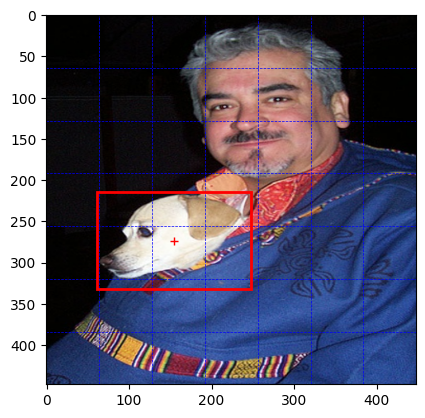

In [4]:
x_center = 0.34419263456090654 * 448  # The number has been taken from the label file
y_center = 0.611 * 448  # from label file
width = 0.4164305949008499 * 448  # from label file
height = 0.262 * 448  # from label file

draw_rectangle_image_rawdata(x_center, y_center, width, height, first_image)

In [5]:
def read(image_filename, label_filename):
    """
    Parameters:
        - image_filename: name of the image
        - label_filename: name of the label file

    Returns
        - the image in the format of a normalized pixel array
        - the label in YOLO format
    """
    ## IMAGE
    # Construct the full path
    images_directory = '/content/data/images/'
    image_path = os.path.join(images_directory, image_filename)
    # Open and resize the image using OpenCV
    image_matrix = cv.imread(image_path)
    image_matrix = cv.cvtColor(image_matrix, cv.COLOR_BGR2RGB)
    image_matrix = cv.resize(image_matrix, (448, 448))
    image_matrix = image_matrix / 255 # normalization of each pixel according to RGB scale

    ## LABEL
    # Construct the full path
    labels_directory = '/content/data/labels/'
    label_path = os.path.join(labels_directory, label_filename)
    # Read the content of the label file, split lines, split values, and convert to int or float
    with open(label_path, 'r') as file:
        label_content = [[float(value) for i, value in enumerate(line.split())] for line in file.read().splitlines()]

    # output shape preparation
    label_matrix = np.zeros([7, 7, 30])

    for l in label_content:
        # class
        cl = int(l[0])

        # saves coordinate of the center points of the element
        x_center = l[1]
        y_center = l[2]
        width = l[3]
        heigth = l[4]

        # adapts x and y coordinates to the grid cell in which the object is
        loc = [7 * x_center, 7 * y_center]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        # coordinates of the object center relative to the grid cell
        y = loc[1] - loc_i
        x = loc[0] - loc_j

        # check if there is not already another element in the same grid cell (if yes: do nothing)
        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cl] = 1 # class
            label_matrix[loc_i, loc_j, 20:24] = [x, y, width, heigth] # coordinates
            label_matrix[loc_i, loc_j, 24] = 1  # confidence presence of element within this bounding box

    return image_matrix, label_matrix

In [6]:
def draw_rectangle_image_yolo(yolo_matrix, image):
    """
    Display an image, the grid cells, and rectangles from YOLO format matrix.
    """
    # Create the figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Calculate grid cell size
    cell_width = image.shape[1] / 7
    cell_height = image.shape[0] / 7

    # Draw vertical grid lines
    for i in range(1, 7):
        x = i * cell_width
        ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)

    # Draw horizontal grid lines
    for j in range(1, 7):
        y = j * cell_height
        ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#FF5733', '#33FF57', '#5733FF', '#33FFFF',
              '#FF33A1', '#A1FF33', '#FF3385', '#FF8533', '#33FFC1', '#C1FF33', '#FF335A', '#335AFF']
    for line in range(7):
        for column in range(7):
            if np.any(yolo_matrix[line, column] != 0):
                # Extract relevant information from YOLO matrix
                x_center_rel, y_center_rel, width_rel, height_rel = yolo_matrix[line, column, 20:24]

                # Calculate absolute coordinates and dimensions
                x_center = (column + x_center_rel)/7 *448
                y_center = (line + y_center_rel)/7 * 448
                width = width_rel * 448
                height = height_rel * 448

                # Extract the class to define the color
                cls = np.argmax(yolo_matrix[line, column, :20] == 1)

                # Add a rectangle to the plot
                rectangle = patches.Rectangle(
                    (x_center - width / 2, y_center - height / 2),
                    width,
                    height,
                    edgecolor=colors[cls],
                    facecolor='none',  # No filling
                    linewidth=2,
                )
                ax.add_patch(rectangle)
                rectangle.set_zorder(3)  # Place the rectangle in front

                # Add the cross in the center
                ax.plot(x_center, y_center, color=colors[cls], marker='+', linewidth=2)

    # Display the plot
    plt.show()

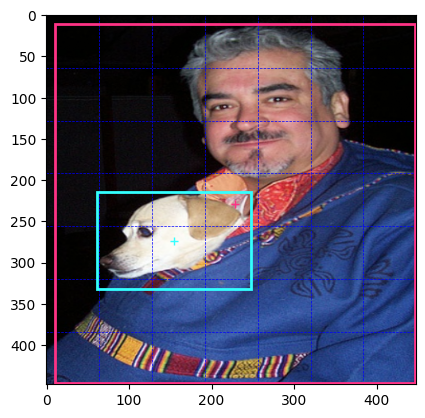

In [7]:
number = '001' # 3 digits
image_name = '000' + number + '.jpg'
label_name = '000' + number + '.txt'

image_matrix, label_matrix = read(image_name, label_name)
draw_rectangle_image_yolo(label_matrix,image_matrix)

In [8]:
class My_Custom_Generator(keras.utils.Sequence) :
    """
    Create a generator to transform a batch of images and their labels into YOLO format, batch after batch
    """
    def __init__(self, images_filenames, labels_filenames, batch_size):
        """
        Initialize the generator with the paths of the images and labes, an the disired size of the batch

        Parameters:
            - images_filenames: array of images' names
            - labels_filenames: array of labels' names
            - batch_size: the desired size of the batch
        """
        self.images = images_filenames
        self.labels = labels_filenames
        self.batch_size = batch_size


    def __len__(self):
        """
        This method returns the total number of batches of batch_size that the generator can produce
        """
        return (np.ceil(len(self.images) / self.batch_size)).astype(int)
        # np.ceil ensures that even if the total number of examples is not perfectly divisible by the batch size, it returns an integer (rounding up)


    def __getitem__(self, idx):
        """
        This method is called to obtain a batch of images and labels in YOLO format at index idx
        Return:
            - np.array of a batch of images normalized and resized
            - np.array of a batch of labels in the YOLO format (7x7x30)
        """
        # Lists' division according to the batch size
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        set_image = []
        set_label = []

        for i in range(0, len(batch_x)):
            image_filename = batch_x[i]
            label_filename = batch_y[i]
            image_matrix, label_matrix = read(image_filename, label_filename)
            set_image.append(image_matrix)
            set_label.append(label_matrix)

        return np.array(set_image), np.array(set_label)


The image is 000021.jpg
The label matrix's shape is now (7, 7, 30)


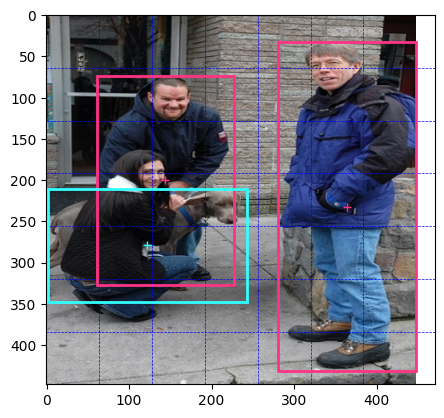

In [9]:
images_directory = '/content/data/images/'
image_files = sorted(os.listdir(images_directory))[:100]
labels_directory = '/content/data/labels/'
label_files = sorted(os.listdir(labels_directory))[:100]
batch_size = 10
idx = 2

# Lists' division according to the batch size
batch_x = image_files[idx * batch_size : (idx+1) * batch_size]
batch_y = label_files[idx * batch_size : (idx+1) * batch_size]

set_image = []
set_label = []

for i in range(0, len(batch_x)):
    image_name = batch_x[i]
    label_name = batch_y[i]
    image_matrix, label_matrix = read(image_name, label_name)
    set_image.append(image_matrix)
    set_label.append(label_matrix)

print(f'The image is {image_files[idx*batch_size]}')
print(f'The label matrix\'s shape is now {set_label[0].shape}')
draw_rectangle_image_yolo(set_label[0],set_image[0])

In [10]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        # Ensure that the characteristics of the parent class are taken into account
        super(Yolo_Reshape, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input): # forward propagation
        # grids 7x7
        S = [self.target_shape[0], self.target_shape[1]]
        # classes
        C = 20
        # no of prediction per grid
        B = 2

        idx1 = S[0] * S[1] * C # 7x7xclasses
        idx2 = idx1 + S[0] * S[1] * B # previous part + 7x7x2

        # class probabilities
        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C])) # Select class predictions of each grid cell
        class_probs = K.softmax(class_probs) # Apply softmax on the class probabilities -> sum=1

        #confidence
        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs) # Apply sigmoid to obtain confidence between [0, 1]

        # boxes
        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes) # Apply sigmoid to obtain bounding box features between [0 ,1]

        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs

In [11]:
# Convert x, y, and w, h coordinates into minmax format
def xywh2minmax(xy, wh):
    """
    Converts bounding box coordinates from center (x, y) and width-height (w, h) format to minimum-maximum format
    """
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


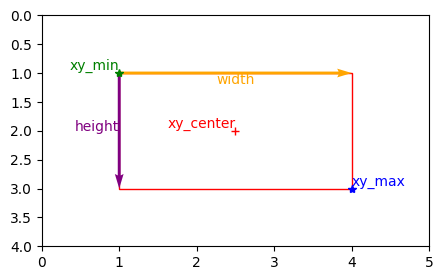

In [12]:
# Visualisation
x_center = 2.5
y_center = 2
width = 3
height = 2
x_min, x_max = xywh2minmax(x_center,width)
y_min, y_max = xywh2minmax(y_center,height)

# Create the figure and axes
fig, ax = plt.subplots(figsize = (5,3))

# Add a rectangle to the plot
rectangle = patches.Rectangle(
    (x_min, y_min),
    width,
    height,
    edgecolor = 'red',
    facecolor='none',  # No filling
)
ax.add_patch(rectangle)

# Add the crosses
ax.plot(x_center, y_center, 'r+')
ax.text(x_center, y_center, 'xy_center', color='red', verticalalignment='bottom', horizontalalignment='right')
ax.plot(x_max, y_max, 'b*')
ax.text(x_max, y_max, 'xy_max', color='blue', verticalalignment='bottom', horizontalalignment='left')
ax.plot(x_min, y_min, 'g*')
ax.text(x_min, y_min, 'xy_min', color='green', verticalalignment='bottom', horizontalalignment='right')

ax.quiver(x_min, y_min, (x_max-x_min), 0, angles='xy', scale_units='xy', scale=1, color='orange')
ax.text(x_center, y_min, 'width', fontsize=10, ha='center', va='top', color = 'orange')
ax.quiver(x_min, y_min, 0, (y_max-y_min), angles='xy', scale_units='xy', scale=1, color='purple')
ax.text(x_min, y_center, 'height', fontsize=10, ha='right', color = 'purple')

ax.set_xlim(0, 5)
ax.set_ylim(0, 4)
ax.invert_yaxis()

# Display the plot
plt.show()

In [13]:
def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    """
    Computes the Intersection over Union score between two boxes (predicted and ground truth)

    Parameters:
        - pred_mins: tensor [x, y] coordinates of the minimum point of the prediction
        - pred_maxes: tensor [x, y] coordinates of the maximum point of the prediction
        - true_mins: tensor [x, y] coordinates of the minimum point of the ground truth
        - true_mins: tensor [x, y] coordinates of the maximum point of the ground truth

    Return: the overlap score between prediction and ground truth
    """
    ## INTERSECTION
    # Keep the max of the min coordinates
    intersect_mins = K.maximum(pred_mins, true_mins)
    # Keep the min of the max coordinates
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    # Intersection area's width and heigh
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    # Area = width*height
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    ## UNION
    pred_wh = pred_maxes - pred_mins # prediction width and height
    true_wh = true_maxes - true_mins # true height width and height
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # prediction areas
    true_areas = true_wh[..., 0] * true_wh[..., 1] # true areas
    union_areas = pred_areas + true_areas - intersect_areas

    iou_scores = intersect_areas / ( union_areas + 1e-10)

    return iou_scores


In [14]:
def yolo_head(feats):
    """
    Convert bounding box features into two separate tensors: xy coordinates and dimensions (weight and height).
    - xy coordinates are converted from grid cell scale to image scale
    - dimensions were and remain at image scale
    Finally, scales the coordinates and dimensions to the original image size (x448).

    Parameter:
        - feats: bounding box tensor only in the shape of (batch_size, 7, 7, n_box, [x, y, w, h])

    Return:
        - box_xy: tensor of shape (batch_size, 7, 7, n_box, [x, y])
        - box_wh: tensor of shape (batch_size, 7, 7, n_box, [w, h])
    """
    conv_dims = K.shape(feats)[1:3]  # shape=(2) -> [7. 7.]

    conv_height_index = K.arange(0, stop=conv_dims[0]) # -> [0, 1, 2, 3, 4, 5, 6]
    conv_width_index = K.arange(0, stop=conv_dims[1]) # idem
    # Repeat the height and width indices for each width value -> create a complete grid of indices
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]]) # shape=(49,) -> [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, ..., 4, 5, 6]
    conv_width_index = K.tile( K.expand_dims(conv_width_index, 0), [conv_dims[0], 1]) # shape=(7, 7)
            #  [[0 1 2 3 4 5 6]
            #        ...
            #  [0 1 2 3 4 5 6]]
    conv_width_index = K.flatten(K.transpose(conv_width_index)) # shape=(49,) -> [0, 0, 0, 0, 0, 0, 1, 1, 1, ..., 6, 6, 6]

    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats)) # shape=(batch_size, 7, 7, 1, 2)
            # [[[[[0. 0.]]
            #    [[1. 0.]]
            #    [[2. 0.]]
            #    [[3. 0.]]
            #    [[4. 0.]]
            #    [[5. 0.]]
            #    [[6. 0.]]]

            #   [[[0. 1.]]
            #    [[1. 1.]]
            #    [[2. 1.]]
            #    [[3. 1.]]

            #      ...
            #    [[4. 6.]]
            #    [[5. 6.]]
            #    [[6. 6.]]]]]

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats)) # shape=(batch_size, 1, 1, 1, 2) -> [[[[[7. 7.]]]]]

    # Multiplication by 448
    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448 # -> shape=(batch_size, 7, 7, 7, 2)
    box_wh = feats[..., 2:4] * 448 # -> shape=(batch_size, 7, 7, 2)

    return box_xy, box_wh

In [15]:
def yolo_loss(y_true, y_pred):
    """
    Extracts class labels, confidence score, and bounding box coordinates from both true labels and predictions.
    Computes the Intersection over Union scores and identifies the best IOU for each predicted box.
    Defines confidence loss (confidence_loss), class prediction loss (class_loss), and bounding box loss (box_loss).
    Combines the losses with specified weights (0.5 for no object confidence, 5 for coordinates/dimensions, square root for dimensions).
    Compute the total loss as the sum of individual losses.

    Parameters:
    - y_true: tensor of ground truth
    - y_pred: tensor of predictions by the model

    Output:
    - loss: scalar representing the loss of the model
    """
    #  Extracts the TRUE class labels from the ground truth tensor
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    # 1 confidence: the 25th channel indicates whether object is present in grid cell
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1 -> Expands dimensions to make it compatible for further operations
    # 1 true bounding box
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4


    # Extracts the PREDICTED class probabilities from the model's output tensor
    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    # 2 confidences
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    # 2 bounding boxes
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    # Reshapes the bounding box coordinates to have an additional dimension, preparing it for further calculations.
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    # Scale coordinates to image scale and multiply by 448
    label_xy, label_wh = yolo_head(_label_box)  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    # Expands the dimensions
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # (? * 7 * 7 * 1 * 1 * 2), (? * 7 * 7 * 1 * 1 * 2)

    # Scale coordinates to image scale and multiply by 448
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)
    # Expands the dimensions
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # (? * 7 * 7 * 2 * 1 * 2), (? * 7 * 7 * 2 * 1 * 2)

    # IOU SCORE between predict and truth
    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    # Reshape iou_scores
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    # Selects the best iou score among the two predicted boxes
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    # Assign 1 to the best bounding box, 0 to the other one
    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    # LOSS CALCULATION
    ## Confidence loss: no object
    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    # True Positive  0.5 * (1 -    1     *       1      ) *         (0 -     0.9  )² = 0 -> because there is actually an object
    # True Negative  0.5 * (1 -   0/1    *       0      ) *         (0 -     0.1  )² = 0.005 (low cost)
    # False Postive  0.5 * (1 -    1     *       0      ) *         (0 -     0.9  )² = 0.405 (medium cost)
    # False Negative 0.5 * (1 -    1     *       1      ) *         (0 -     0.1  )² = 0 -> because there is actually an object

    ## Confidence loss: object
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    # True Pos       1     *      1        *         (1 -   0.9  )² = 0.01 (low cost)
    # True Neg      0/1    *      0        *         (1 -   0.1  )² = 0 -> because there is actually no object
    # False Pos      1     *      0        *         (1 -   0.9  )² = 0 -> because there is actually no object
    # False Neg      1     *      1        *         (1 -   0.1  )² = 0.81 (high cost)

    # Sums up the confidence loss.
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss) # -> scalar

    ## Classes loss
    # class_loss: Loss for predicted class probabilities
    class_loss = response_mask * K.square(label_class - predict_class)
    # True Pos        obj=1    *         (   dog=1    -   0.9)² = 0.01 (low cost) -> There is a dog, and I'm sure it's a dog

    # True Neg        obj=0    *         (   cat=0    -   0.1)² = 0 -> There is no object, I can predict anything
    # True Neg        obj=1    *         (   boat=0   -   0.1)² = 0.01 (low cost) -> There is a dog, and I know it's not a boat

    # False Pos       obj=0    *         (   cat=0    -   0.9)² = 0 -> There is no object, I can predict anything
    # False Pos       obj=1    *         (   boat=0   -   0.9)² = 0.81 (high cost) -> There is a dog, but I'm sure it's a boat

    # False Neg       obj=1    *         (   dog=1    -   0.1)² = 0.81 (high cost) -> There is a dog, but I'm sure it's not a dog
    # Sums up the class loss
    class_loss = K.sum(class_loss) # -> scalar

    # Reshaping operations
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    label_xy, label_wh = yolo_head(_label_box)        # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    box_mask = K.expand_dims(box_mask)           # ? * 7 * 7 * 2 * 1
    response_mask = K.expand_dims(response_mask) # ? * 7 * 7 * 1 * 1

    ## Bounding boxes loss
    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    # True Pos  5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -   0.6/sqrt(0.6))² = 0.05 / 0.02 (low cost)
    # True Neg  5 *  0/1    *      0     *     (  0/sqrt(0)     -   0.1/sqrt(0.1))² = 0 -> I can predict anything
    # False Pos 5 *   1     *      0     *     (  0/sqrt(0)     -   0.5/sqrt(0.5))² = 0 -> I can predict anything
    # False Neg 5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -     0/sqrt(0)  )² = 1.25 / 2.5 (really high cost)
    box_loss = K.sum(box_loss) # -> scalar

    # Combines the three components to get the final loss
    loss = confidence_loss + class_loss + box_loss

    return loss


In [19]:
# This is just a test to understand the box_mask behavior
shape_true = (1, 1, 1, 1, 1, 2)
shape_predict = (1, 1, 1, 2, 1, 2)

true_xy_min = np.zeros(shape_true)
true_xy_max = np.zeros(shape_true)
predict_xy_min = np.zeros(shape_predict)
predict_xy_max = np.zeros(shape_predict)

true_xy_min[0,0,0,0]=[0, 0]
true_xy_max[0,0,0,0]=[0, 0]

predict_xy_min[0,0,0] = [ [[5, 4]], [[1.5, 2]] ]
predict_xy_max[0,0,0] = [ [[5.05, 4.05]], [[1.5, 2]] ]

true_xy_min = tf.convert_to_tensor(true_xy_min)
true_xy_max = tf.convert_to_tensor(true_xy_max)
predict_xy_min = tf.convert_to_tensor(predict_xy_min)
predict_xy_max = tf.convert_to_tensor(predict_xy_max)

iou_scores = iou(predict_xy_min, predict_xy_max, true_xy_min, true_xy_max)  # ? * 7 * 7 * 2 * 1
best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
best_box = K.max(best_ious, axis=3, keepdims=True)
box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2
box_mask = K.expand_dims(box_mask, axis= -1)

print(f'iou_scores: {iou_scores[0,0,0]}')
print(f'best_ious: {best_ious[0,0,0]}')
print(f'best_box: {best_box[0,0,0]}')
print(f'box_mask: {box_mask[0,0,0]}')


iou_scores: [[0.]
 [0.]]
best_ious: [0. 0.]
best_box: [0.]
box_mask: [[1.]
 [1.]]


In [31]:
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

def yolo_cnn(input_shape):
    model = Sequential()
    # Conv. layer 1
    model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(2, 2), input_shape =input_shape, padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layer 2
    model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layer 3
    model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # lConv. layer 4
    model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 5
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 6
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 7-14
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv.layer 15
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 16
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 4
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 17-20
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 21
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 22
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

    # Conv. layer 23
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 24
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))

    model.add(Flatten()) # Transform the last output into a single vector

    model.add(Dense(4096))
    model.add(Dropout(0.5)) # Dropout rate to prevent overfitting
    model.add(Dense(1470, activation='sigmoid'))
    model.add(Yolo_Reshape(target_shape=(7,7,30)))

    model.compile(loss=yolo_loss, optimizer='adam')

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [49]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

      Argument:
      schedule: a function that takes an epoch index (integer, indexed from 0) and current learning rate
      as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        # checks whether the optimizer has a LR attribute
        if not hasattr(self.model.optimizer, "lr"):
            # IF `lr` attribute is missing, try `learning_rate`
            # This check ensures compatibility with different Keras versions
            if hasattr(self.model.optimizer, "learning_rate"):
                # Replace `lr` with `learning_rate`
                lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
            else:
                # Handle case where neither `lr` nor `learning_rate` is found
                raise ValueError("Optimizer doesn't have a learning rate attribute.")

        else:
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)


         # Debugging statements (using tf.print for Colab to ensure visibility)
        tf.print("Epoch:", epoch)
        tf.print("Current learning rate:", lr)
        tf.print("Optimizer learning rate attribute type:", type(self.model.optimizer.learning_rate))

        # Call the provided schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        scheduled_lr = float(scheduled_lr)  # Explicit conversion to float

        tf.print("Scheduled learning rate:", scheduled_lr)

        # Set the scheduled learning rate back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


# Define a schedule of learning rates at specific epochs
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    # If the epoch is before the first scheduled change or after the last, keep the current learning rate
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    # Iterate through the schedule and return the learning rate if the epoch matches a scheduled change
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]

    # If the epoch is not in the schedule, keep the current learning rate
    return lr

In [22]:
images_directory = '/content/data/images/'
labels_directory = '/content/data/labels/'

# Create lists of images' and labels' names
images_list = os.listdir(images_directory)
labels_list = os.listdir(labels_directory)
print('*** Before ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}\n')

# Extract file names without extension (.jpg or .txt)
images_noextension_set = set([os.path.splitext(image)[0] for image in images_list])
labels_noextension_set = set([os.path.splitext(label)[0] for label in labels_list])

# Find file names in common between the two sets
intersection_set = labels_noextension_set.intersection(images_noextension_set)

# Create two sorted lists of file names with the extensions
images_list = sorted([f"{filename}.jpg" for filename in intersection_set])
labels_list = sorted([f"{filename}.txt" for filename in intersection_set])
print('*** After ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}')


*** Before ***
Image list length: 27088
Label list length: 21503

*** After ***
Image list length: 21503
Label list length: 21503


In [23]:
images_list_small = images_list[:21440]
labels_list_small = labels_list[:21440]

# Split Data into Training and Testing size -> 20%
X_train_temp, X_test_filenames, Y_train_temp, Y_test_filenames = train_test_split(images_list_small, labels_list_small, test_size=0.2, random_state=456)

# Split training data into training and evaluation set -> 20% of the entire dataset or 1/4 of the train set
X_train_filenames, X_val_filenames, Y_train_filenames, Y_val_filenames = train_test_split(X_train_temp, Y_train_temp, test_size=(1/4), random_state=456)

print(f'Train shape: {len(X_train_filenames)}')
print(f'Validation shape: {len(X_val_filenames)}')
print(f'Test shape: {len(X_test_filenames)}')

Train shape: 12864
Validation shape: 4288
Test shape: 4288


In [41]:
batch_size = 64

# Initialize three generators (train, validation and test)
my_training_batch_generator = My_Custom_Generator(X_train_filenames, Y_train_filenames, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, Y_val_filenames, batch_size)

# Verification
X_train_gen, Y_train_gen = my_training_batch_generator.__getitem__(0)
print(f'Training set shape: {X_train_gen.shape}')
print(f'Training target shape: {Y_train_gen.shape}')

Training set shape: (64, 448, 448, 3)
Training target shape: (64, 7, 7, 30)


In [42]:
input_shape = (X_train_gen.shape[1], X_train_gen.shape[2], X_train_gen.shape[3])

model = yolo_cnn(input_shape)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 112, 112, 192)       │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 56, 56, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 56, 56, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 56, 56, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 28, 28, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 28, 28, 512)         │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 28, 28, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 14, 14, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 271,703,550 (1.01 GB)

 Trainable params: 271,703,550 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

In [50]:
yolo_trained = model.fit(
            x=my_training_batch_generator,
            epochs = 135,
            validation_data = my_validation_batch_generator,
            callbacks=[
              CustomLearningRateScheduler(lr_schedule),
            ],
            verbose = 2
)

Epoch: 0
Current learning rate: 0.001
Optimizer learning rate attribute type: <class 'keras.src.backend.tensorflow.core.Variable'>
Scheduled learning rate: 0.01


AttributeError: 'str' object has no attribute 'name'